In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [7]:
# First Step: Loading Datasets
data_test = spark.read.csv("classificationAssets/Classification_Test.csv", header=True, inferSchema=True)
data_train = spark.read.csv("classificationAssets/Classification_Train.csv", header=True, inferSchema=True)

data_test.show(5)
data_train.show(5)

+----------------+------+------+---------------+---------+-------+-------------+---------+
|            Name|Gender|Height|Education Level|Eye Color|Married|Salary Income|Depressed|
+----------------+------+------+---------------+---------+-------+-------------+---------+
|    Lila Bracher|  Male|   151|            Low|    Black|     No|     74000000|      Yes|
|Archibaldo Bigly|  Male|   162|           High|     Blue|    Yes|     29000000|       No|
|    Dion Stopher|  Male|   155|   Intermediate|    Brown|    Yes|    134000000|       No|
|  Genna Hallagan|  Male|   143|   Intermediate|     Blue|     No|     13000000|      Yes|
|       Alis Fass|Female|   163|            Low|     Blue|    Yes|      7000000|      Yes|
+----------------+------+------+---------------+---------+-------+-------------+---------+
only showing top 5 rows

+----------------+------+------+---------------+---------+-------+-------------+---------+
|            Name|Gender|Height|Education Level|Eye Color|Married

In [8]:
# Second Step: Select Features
data_test_features = data_test.select("Education Level", "Married", "Salary Income", "Depressed")
data_train_features = data_train.select("Education Level", "Married", "Salary Income", "Depressed")

data_test_features.show(5)
data_train_features.show(5)

+---------------+-------+-------------+---------+
|Education Level|Married|Salary Income|Depressed|
+---------------+-------+-------------+---------+
|            Low|     No|     74000000|      Yes|
|           High|    Yes|     29000000|       No|
|   Intermediate|    Yes|    134000000|       No|
|   Intermediate|     No|     13000000|      Yes|
|            Low|    Yes|      7000000|      Yes|
+---------------+-------+-------------+---------+
only showing top 5 rows

+---------------+-------+-------------+---------+
|Education Level|Married|Salary Income|Depressed|
+---------------+-------+-------------+---------+
|   Intermediate|    Yes|     85000000|       No|
|   Intermediate|     No|     14000000|       No|
|            Low|     No|    148000000|      Yes|
|           High|     No|     50000000|      Yes|
|   Intermediate|    Yes|    101000000|       No|
+---------------+-------+-------------+---------+
only showing top 5 rows



In [9]:
# Third Step: Data Preprocessing -> Cleaning Data that contains NULL and Outliers
data_test_cleaned = data_test_features.na.drop()
data_train_cleaned = data_train_features.na.drop()

data_test_cleaned.show(5)
data_train_cleaned.show(5)

+---------------+-------+-------------+---------+
|Education Level|Married|Salary Income|Depressed|
+---------------+-------+-------------+---------+
|            Low|     No|     74000000|      Yes|
|           High|    Yes|     29000000|       No|
|   Intermediate|    Yes|    134000000|       No|
|   Intermediate|     No|     13000000|      Yes|
|            Low|    Yes|      7000000|      Yes|
+---------------+-------+-------------+---------+
only showing top 5 rows

+---------------+-------+-------------+---------+
|Education Level|Married|Salary Income|Depressed|
+---------------+-------+-------------+---------+
|   Intermediate|    Yes|     85000000|       No|
|   Intermediate|     No|     14000000|       No|
|            Low|     No|    148000000|      Yes|
|           High|     No|     50000000|      Yes|
|   Intermediate|    Yes|    101000000|       No|
+---------------+-------+-------------+---------+
only showing top 5 rows



In [10]:
# Fourth Step: Data Transformation -> Transforming Categorical Data into Numerical Data
from pyspark.sql.functions import when

# Transforming Test Data
data_test_transformed = data_test_cleaned.withColumn(
    "Married", when(data_test_cleaned["Married"] == "No", 0).
               when(data_test_cleaned["Married"] == "Yes", 1)
).withColumn(
    "Education Level", when(data_test_cleaned["Education Level"] == "Low", 0).
                       when(data_test_cleaned["Education Level"] == "Intermediate", 1).
                       when(data_test_cleaned["Education Level"] == "High", 2)
).withColumn(
    "Depressed", when(data_test_cleaned["Depressed"] == "Yes", 1).
                when(data_test_cleaned["Depressed"] == "No", 0)
)

# Transforming Training Data
data_train_transformed = data_train_cleaned.withColumn(
    "Married", when(data_train_cleaned["Married"] == "Yes", 1).
               when(data_train_cleaned["Married"] == "No", 0)
).withColumn(
    "Education Level", when(data_train_cleaned["Education Level"] == "Low", 0).
                       when(data_train_cleaned["Education Level"] == "Intermediate", 1).
                       when(data_train_cleaned["Education Level"] == "High", 2)
).withColumn(
    "Depressed", when(data_train_cleaned["Depressed"] == "Yes", 1).
                when(data_train_cleaned["Depressed"] == "No", 0)
)

data_test_transformed.show(5)
data_train_transformed.show(5)

+---------------+-------+-------------+---------+
|Education Level|Married|Salary Income|Depressed|
+---------------+-------+-------------+---------+
|              0|      0|     74000000|        1|
|              2|      1|     29000000|        0|
|              1|      1|    134000000|        0|
|              1|      0|     13000000|        1|
|              0|      1|      7000000|        1|
+---------------+-------+-------------+---------+
only showing top 5 rows

+---------------+-------+-------------+---------+
|Education Level|Married|Salary Income|Depressed|
+---------------+-------+-------------+---------+
|              1|      1|     85000000|        0|
|              1|      0|     14000000|        0|
|              0|      0|    148000000|        1|
|              2|      0|     50000000|        1|
|              1|      1|    101000000|        0|
+---------------+-------+-------------+---------+
only showing top 5 rows



In [11]:
# Fifth Step: Doing Normalization using StandardScaler and VectorAssembler
from pyspark.ml.feature import StandardScaler, VectorAssembler

cols = data_test_transformed.columns
cols.remove("Depressed")

data_train_transformed = VectorAssembler(inputCols=cols, outputCol="Features").transform(data_train_transformed)
scaler = StandardScaler(inputCol="Features", outputCol="scaled_features")
data_train_transformed = scaler.fit(data_train_transformed).transform(data_train_transformed)

# Do the same thing for Test Data

cols = data_test_transformed.columns
cols.remove("Depressed")

data_test_transformed = VectorAssembler(inputCols=cols, outputCol="Features").transform(data_test_transformed)
scaler = StandardScaler(inputCol="Features", outputCol="scaled_features")
data_test_transformed = scaler.fit(data_test_transformed).transform(data_test_transformed)

data_train_transformed.show(5)
data_test_transformed.show(5)

+---------------+-------+-------------+---------+----------------+--------------------+
|Education Level|Married|Salary Income|Depressed|        Features|     scaled_features|
+---------------+-------+-------------+---------+----------------+--------------------+
|              1|      1|     85000000|        0| [1.0,1.0,8.5E7]|[1.29595742362073...|
|              1|      0|     14000000|        0| [1.0,0.0,1.4E7]|[1.29595742362073...|
|              0|      0|    148000000|        1|[0.0,0.0,1.48E8]|[0.0,0.0,3.572913...|
|              2|      0|     50000000|        1| [2.0,0.0,5.0E7]|[2.59191484724147...|
|              1|      1|    101000000|        0|[1.0,1.0,1.01E8]|[1.29595742362073...|
+---------------+-------+-------------+---------+----------------+--------------------+
only showing top 5 rows

+---------------+-------+-------------+---------+-------------------+--------------------+
|Education Level|Married|Salary Income|Depressed|           Features|     scaled_features|
+

In [12]:
# Sixth Step: Generating Models, Here i will use Logistic Regression for predicting the Depressed or Not
from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(featuresCol="scaled_features", labelCol="Depressed", maxIter = 10).fit(data_train_transformed)

In [13]:
# Seventh Step: Predicting the Test Data and Testing Result using Confusion Matrix
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(data_test_transformed)
predictions.select("Education Level", "Married", "Salary Income","Depressed", "Prediction").show(20)

evaluator = BinaryClassificationEvaluator(labelCol="Depressed")

print("The Area Under ROC is: %.2f%%" %(evaluator.evaluate(predictions)*100))

+---------------+-------+-------------+---------+----------+
|Education Level|Married|Salary Income|Depressed|Prediction|
+---------------+-------+-------------+---------+----------+
|              0|      0|     74000000|        1|       1.0|
|              2|      1|     29000000|        0|       0.0|
|              1|      1|    134000000|        0|       0.0|
|              1|      0|     13000000|        1|       1.0|
|              0|      1|      7000000|        1|       1.0|
|              1|      0|    106000000|        1|       1.0|
|              2|      0|     35000000|        1|       1.0|
|              2|      1|    124000000|        0|       0.0|
|              0|      0|      7000000|        1|       1.0|
|              0|      0|    122000000|        1|       1.0|
|              2|      0|    109000000|        1|       0.0|
|              1|      1|    136000000|        0|       0.0|
|              0|      1|      4000000|        0|       1.0|
|              1|      1

In [14]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


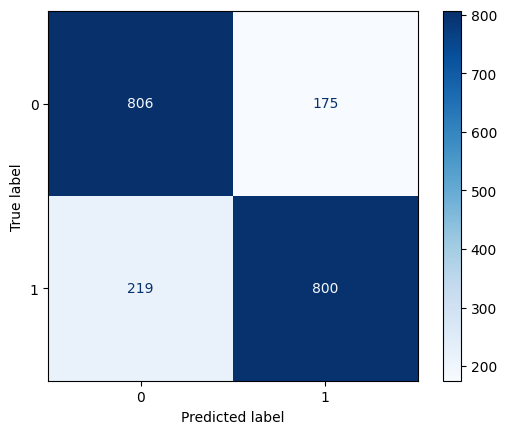

Class 0:
  True Positives (TP): 806
  False Positives(FP): 219
  False Negatives(FN): 175
  True Negatives (TN): 800

Class 1:
  True Positives (TP): 800
  False Positives(FP): 175
  False Negatives(FN): 219
  True Negatives (TN): 806



In [15]:
# Eighth Step: Confusion Matrix and Metrics Calculation using scikit-learn library and matplotlib library for visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_true = predictions.select("Depressed").toPandas()
y_pred = predictions.select("Prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  True Positives (TP): {TP[i]}")
    print(f"  False Positives(FP): {FP[i]}")
    print(f"  False Negatives(FN): {FN[i]}")
    print(f"  True Negatives (TN): {TN[i]}")
    print()

In [41]:
accuracy = ((TP + TN) / (TP + TN + FP + FN))*100
precision = (TP / (TP + FP))*100
recall = (TP / (TP + FN))*100
f1_score = (2 * ((precision * recall) / (precision + recall)))

print("----------------------------------------------")
print("Accuracy  : ", accuracy)
print("Precision : ", precision)
print("Recall    : ", recall)
print("F1 Score  : ", f1_score)
print("----------------------------------------------")


----------------------------------------------
Accuracy  :  [80.3 80.3]
Precision :  [78.63414634 82.05128205]
Recall    :  [82.16106014 78.50834151]
F1 Score  :  [80.35892323 80.24072217]
----------------------------------------------
